## Import Libraries

In [323]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import vaex

# DGL
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable


from plotly.subplots import make_subplots
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as pyo
from itables import init_notebook_mode
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
# Data Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# Data Scaling
from sklearn.preprocessing import MinMaxScaler
# Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# DGL
from dgl.nn import GraphConv, GATConv, AGNNConv, GlobalAttentionPooling
from dgl.data import register_data_args
from dgl.data import CoraGraphDataset


init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [324]:
import torch
print(torch.__version__)

2.0.1+cpu


In [325]:
import os
os.environ['DGLBACKEND'] = 'pytorch'

In [326]:
random.seed(42)
np.random.seed(42)
tables = []

## Load dataset (cleveland data)

### Data Preparation

In [327]:
col_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

In [328]:
cleveland_data = pd.read_csv("processed.cleveland.data", header=None, names = col_names)

In [329]:
cleveland_data

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca thal  target  
0      3.0  0.0  6.0       0  
1      2.0  3.0  3.0       2  
2      2.0  2.0  7.0       1  
3      3.0  0.0  3.0       0  
4      1.0  0.0  3.0       0  
..     ...  ...  ...     ...  
298    2.0  0.0  7.0       1  
299    2.0  2.0  7.0       2  
300    2.0  1.0  7.0       3  
301    2.0  1.0  3.0       1  
302    1.0    ?  3.0       0  

[303 rows x 14 columns]

In [330]:
cleveland_data.to_csv("Cleveland_data_with_columnNames.csv", index = False)

In [331]:
data = cleveland_data

In [332]:
cleveland_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [333]:
cleveland_data.nunique()

age          41
sex           2
cp            4
trestbps     50
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        5
dtype: int64

In [334]:
cleveland_data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [335]:
cleveland_data['target'].value_counts()

0    164
1     55
2     36
3     35
4     13
Name: target, dtype: int64

In [336]:
## change target varible classes (1,2,3,4) = 1 classes
cleveland_data['Target'] = cleveland_data['target'].apply(lambda x: 1 if x >= 1 else 0)

In [337]:
cleveland_data['Target'].value_counts()

0    164
1    139
Name: Target, dtype: int64

In [338]:
cleveland_data.replace('?', pd.NA, inplace = True)

In [339]:
cleveland_data.dropna(inplace = True)

In [340]:
cleveland_data = cleveland_data.drop(columns = 'target')

In [341]:
cleveland_data.describe()

age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    3.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope      Target  
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000  
mean     0.996633  149.599327    0.326599    1.055556    1.602694    0.461279  
std      0.994914   22.941562    0.469761    1.166123    0.618187    0.499340  
min      0.000000   71.000000    0.000000    0.000000    1.000000    0.000000  
25%      0.000000  133.000000    0.000000    0.000000    1.000000    0.000000  
50%      1.000000  153.000000    0.000000    0.800000    2.000000    0.000000  
75%      2.000000  166.000000    1.000000    1.600000    2.000000    1.000000  
max      2.000000  202.000000    1.000000    6.200000    3.000000    1.000000

In [342]:
cleveland_data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'Target'],
      dtype='object')

In [343]:
## Change column format from object to numeric
cleveland_data['ca'] = pd.to_numeric(cleveland_data['ca'], errors='coerce')
cleveland_data['thal'] = pd.to_numeric(cleveland_data['thal'], errors='coerce')

In [344]:
## Change categorical columns format from float to int
categorical_col = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'Target']
numerical_col = ['trestbps', 'chol', 'thalach', 'oldpeak']

cleveland_data[categorical_col] = cleveland_data[categorical_col].astype(int)

In [345]:
cleveland_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    int32  
 2   cp        297 non-null    int32  
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    int32  
 6   restecg   297 non-null    int32  
 7   thalach   297 non-null    float64
 8   exang     297 non-null    int32  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int32  
 11  ca        297 non-null    int32  
 12  thal      297 non-null    int32  
 13  Target    297 non-null    int32  
dtypes: float64(5), int32(9)
memory usage: 24.4 KB


### Outliers handling

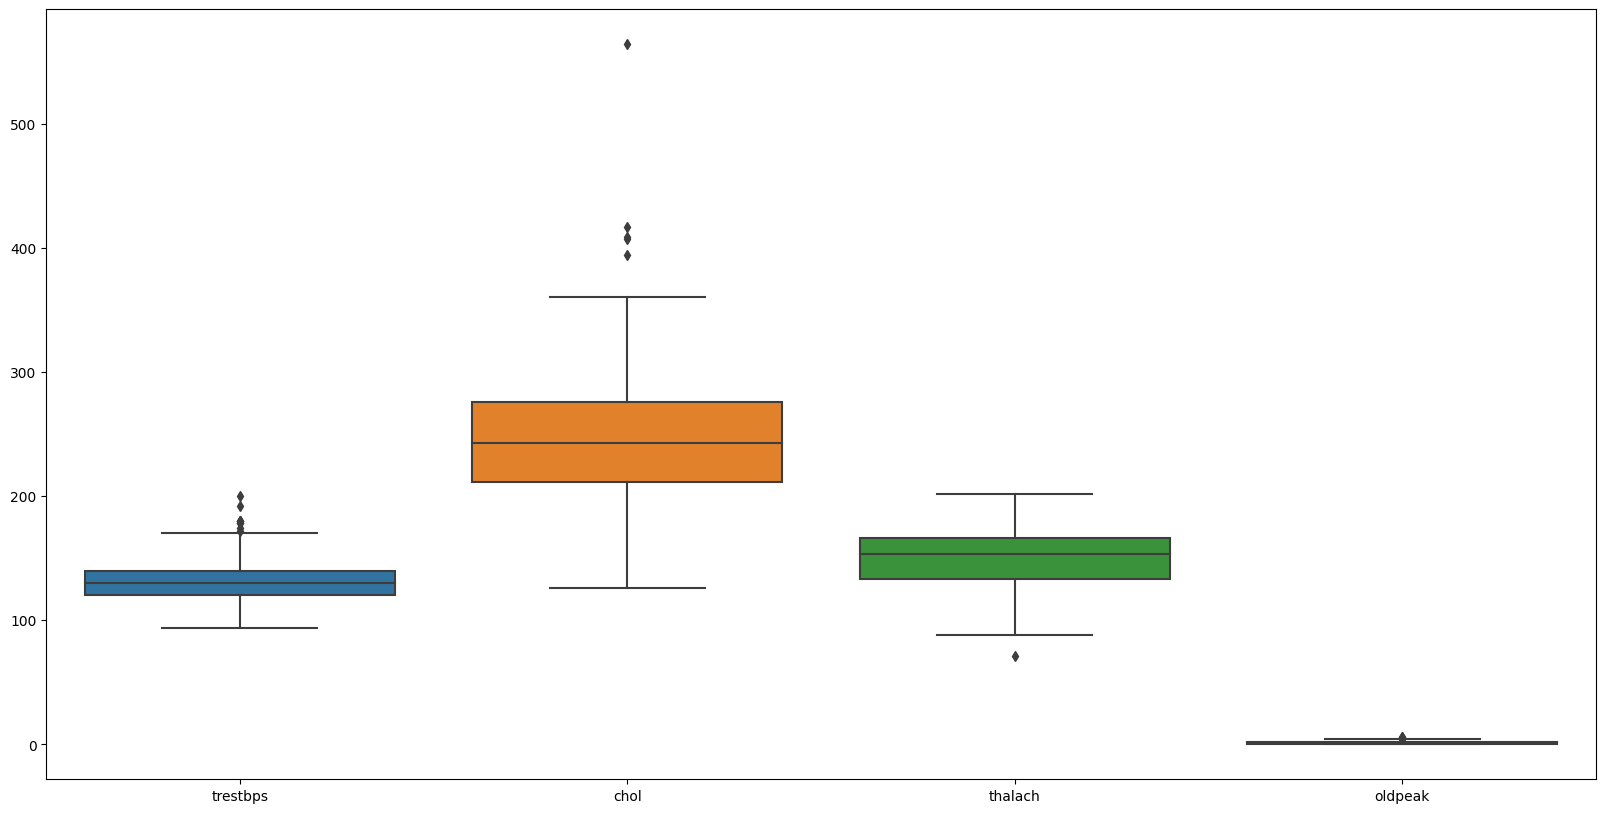

In [346]:
## Numerical features box plots
plt.figure(figsize=(20,10), facecolor='w')
sns.boxplot(data=cleveland_data[numerical_col])
plt.show()

In [347]:
cleveland_data = cleveland_data[cleveland_data['chol'] < 500]

In [348]:
cleveland_data.describe()

age         sex          cp    trestbps        chol        fbs  \
count  296.000000  296.000000  296.000000  296.000000  296.000000  296.00000   
mean    54.500000    0.679054    3.158784  131.750000  246.280405    0.14527   
std      9.035898    0.467631    0.966449   17.766232   48.701920    0.35297   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.00000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.00000   
50%     56.000000    1.000000    3.000000  130.000000  242.500000    0.00000   
75%     61.000000    1.000000    4.000000  140.000000  275.250000    0.00000   
max     77.000000    1.000000    4.000000  200.000000  417.000000    1.00000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  296.000000  296.000000  296.000000  296.000000  296.000000  296.000000   
mean     0.993243  149.564189    0.327703    1.053716    1.601351    0.679054   
std      0.994879   22.972406    0.470171    1.167666    0.618800    0.939726   
min      0.000000   71.000000    0.000000    0.000000    1.000000    0.000000   
25%      0.000000  133.000000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  152.500000    0.000000    0.800000    2.000000    0.000000   
75%      2.000000  166.000000    1.000000    1.650000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    3.000000    3.000000   

             thal      Target  
count  296.000000  296.000000  
mean     4.722973    0.462838  
std      1.937396    0.499461  
min      3.000000    0.000000  
25%      3.000000    0.000000  
50%      3.000000    0.000000  
75%      7.000000    1.000000  
max      7.000000    1.000000

C:\Users\praga\AppData\Local\Temp\ipykernel_18040\2728123188.py:4: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'ca'}>],
       [<Axes: title={'center': 'thal'}>,
        <Axes: title={'center': 'Target'}>, <Axes: >, <Axes: >]],
      dtype=object)

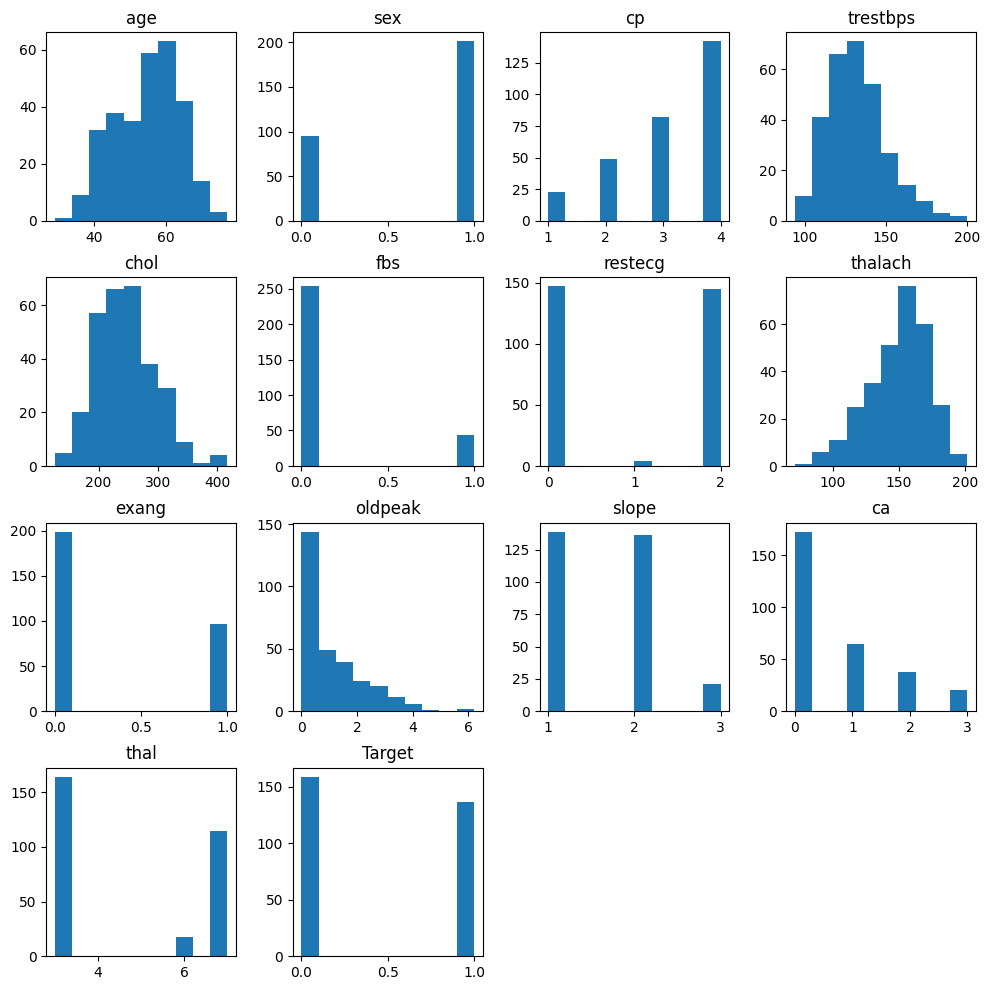

In [349]:
# checking features distributions using histograms
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
cleveland_data.hist(ax = ax, grid = False)

<Axes: >

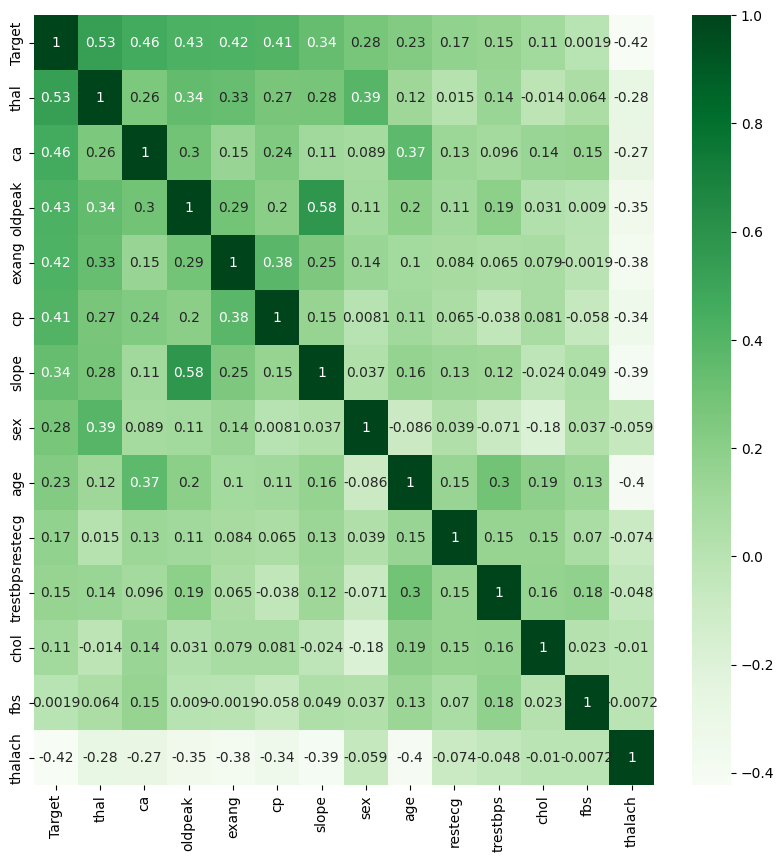

In [350]:
col = cleveland_data.corr().nlargest(31, "Target").Target.index
plt.figure(figsize=(10, 10))
sns.heatmap(cleveland_data[col].corr(), annot=True, cmap='Greens', annot_kws={"size":10})

In [29]:
cleveland_data.to_csv('cleveland_preprocessed_data_ps.csv', index = False)

In [351]:
clev_data = vaex.from_csv("cleveland_preprocessed_data_ps.csv")

# Add an explicit index column
clev_data['index'] = vaex.vrange(start=0, stop=len(clev_data))

# Convert the index column to integer
clev_data['index'] = clev_data['index'].astype('int') + 1
clev_data['pid'] = clev_data['index'].apply(lambda x: f"P{x}")

# Convert the vaex dataframe to dataframe
clev_data = clev_data.to_pandas_df()

In [352]:
clev_data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'Target', 'index', 'pid'],
      dtype='object')

In [353]:
# Change column orders
col_order = ['pid', 'index', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'Target']

clev_data = clev_data[col_order]

# Drop index column
clev_data = clev_data.drop(columns = 'index', axis = 1)
clev_data

pid   age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  \
0      P1  63.0    1   1     145.0  233.0    1        2    150.0      0   
1      P2  67.0    1   4     160.0  286.0    0        2    108.0      1   
2      P3  67.0    1   4     120.0  229.0    0        2    129.0      1   
3      P4  37.0    1   3     130.0  250.0    0        0    187.0      0   
4      P5  41.0    0   2     130.0  204.0    0        2    172.0      0   
..    ...   ...  ...  ..       ...    ...  ...      ...      ...    ...   
291  P292  57.0    0   4     140.0  241.0    0        0    123.0      1   
292  P293  45.0    1   1     110.0  264.0    0        0    132.0      0   
293  P294  68.0    1   4     144.0  193.0    1        0    141.0      0   
294  P295  57.0    1   4     130.0  131.0    0        0    115.0      1   
295  P296  57.0    0   2     130.0  236.0    0        2    174.0      0   

     oldpeak  slope  ca  thal  Target  
0        2.3      3   0     6       0  
1        1.5      2   3     3       1  
2        2.6      2   2     7       1  
3        3.5      3   0     3       0  
4        1.4      1   0     3       0  
..       ...    ...  ..   ...     ...  
291      0.2      2   0     7       1  
292      1.2      2   0     7       1  
293      3.4      2   2     7       1  
294      1.2      2   1     7       1  
295      0.0      2   1     3       1  

[296 rows x 15 columns]

### Feature Scaling

In [354]:
## scale numeric features
scaler = StandardScaler()
columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
clev_data[columns_to_scale] = scaler.fit_transform(clev_data[columns_to_scale])

In [355]:
clev_data

pid       age  sex  cp  trestbps      chol  fbs  restecg   thalach  \
0      P1  0.942285    1   1  0.747060 -0.273149    1        2  0.019003   
1      P2  1.385714    1   4  1.592788  0.816946    0        2 -1.812373   
2      P3  1.385714    1   4 -0.662487 -0.355421    0        2 -0.896685   
3      P4 -1.939999    1   3 -0.098668  0.076504    0        0  1.632359   
4      P5 -1.496571    0   2 -0.098668 -0.869617    0        2  0.978296   
..    ...       ...  ...  ..       ...       ...  ...      ...       ...   
291  P292  0.277143    0   4  0.465150 -0.108607    0        0 -1.158310   
292  P293 -1.053142    1   1 -1.226306  0.364454    0        0 -0.765872   
293  P294  1.496571    1   4  0.690678 -1.095863    1        0 -0.373435   
294  P295  0.277143    1   4 -0.098668 -2.371069    0        0 -1.507144   
295  P296  0.277143    0   2 -0.098668 -0.211446    0        2  1.065504   

     exang   oldpeak  slope  ca  thal  Target  
0        0  1.069137      3   0     6       0  
1        1  0.382849      2   3     3       1  
2        1  1.326494      2   2     7       1  
3        0  2.098568      3   0     3       0  
4        0  0.297063      1   0     3       0  
..     ...       ...    ...  ..   ...     ...  
291      1 -0.732369      2   0     7       1  
292      0  0.125491      2   0     7       1  
293      0  2.012782      2   2     7       1  
294      1  0.125491      2   1     7       1  
295      0 -0.903941      2   1     3       1  

[296 rows x 15 columns]

In [356]:
clev_data.to_csv("Cleveland_scaled_data.csv", index = False)

### Train & Validation split

In [35]:
X = clev_data.drop(['Target', 'pid'], axis=1)
y = clev_data['Target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(236, 13)
(60, 13)
(236,)
(60,)


### Model Building and Evaluation

<h4><strong><font color="blue">Logistic Regression</font></strong></h4>

In [37]:
## Model building 

# Fit the model
m1 = LogisticRegression(random_state=42, max_iter = 1000)
m1.fit(X_train, y_train)

######################################################################################
# Make predictions on the train set
y_pred_train = m1.predict(X_train)

# Calculate evaluation metrics
f1 = round(f1_score(y_train, y_pred_train), 2)
auc = round(roc_auc_score(y_train, y_pred_train), 2)
precision = round(precision_score(y_train, y_pred_train), 2)
recall = round(recall_score(y_train, y_pred_train), 2)
accuracy = round(accuracy_score(y_train, y_pred_train), 2)

# Print Classification report and confusion matrix
print("TRAIN SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_train, y_pred_train)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
print("True Negatives: ",tn_train)
print("False Positives: ",fp_train)
print("False Negatives: ",fn_train)
print("True Positives: ",tp_train)

# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn_train]
]

# Print the evaluation metrics in a table
t1_train = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m1: Logistic Regression', t1_train))
print(t1_train)

##########################################################################################
# Make predictions on the test set
y_pred = m1.predict(X_val)


# Calculate evaluation metrics
f1 = round(f1_score(y_val, y_pred), 2)
auc = round(roc_auc_score(y_val, y_pred), 2)
precision = round(precision_score(y_val, y_pred), 2)
recall = round(recall_score(y_val, y_pred), 2)
accuracy = round(accuracy_score(y_val, y_pred), 2)

# Print Classification report and confusion matrix
print("\nVALIDATION SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_val,y_pred)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_val, y_pred)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)


# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn]
]

# Print the evaluation metrics in a table
t1_val = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m1: Logistic Regression', t1_val))
print(t1_val)

TRAIN SET RESULTS: 
CONFUSION MATRIX:
[[105  16]
 [ 23  92]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       121
           1       0.85      0.80      0.83       115

    accuracy                           0.83       236
   macro avg       0.84      0.83      0.83       236
weighted avg       0.84      0.83      0.83       236

True Negatives:  105
False Positives:  16
False Negatives:  23
True Positives:  92
╒═════════════════╤═════════╕
│ Metric          │   Value │
╞═════════════════╪═════════╡
│ F1 Score        │    0.83 │
├─────────────────┼─────────┤
│ AUC Score       │    0.83 │
├─────────────────┼─────────┤
│ Precision       │    0.85 │
├─────────────────┼─────────┤
│ Recall          │    0.8  │
├─────────────────┼─────────┤
│ Accuracy        │    0.83 │
├─────────────────┼─────────┤
│ False Negatives │   23    │
╘═════════════════╧═════════╛

VALIDATION SET RESULTS: 
CONFUSION MATRIX:
[[35  3]
 [

<h4><strong><font color="blue">Random Forest Classifier</font></strong></h4>

In [38]:
# Fit the model
m2 = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=12)
m2.fit(X_train, y_train)

######################################################################################
# Make predictions on the train set
y_pred_train = m2.predict(X_train)

# Calculate evaluation metrics
f1 = round(f1_score(y_train, y_pred_train), 2)
auc = round(roc_auc_score(y_train, y_pred_train), 2)
precision = round(precision_score(y_train, y_pred_train), 2)
recall = round(recall_score(y_train, y_pred_train), 2)
accuracy = round(accuracy_score(y_train, y_pred_train), 2)

# Print Classification report and confusion matrix
print("TRAIN SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_train, y_pred_train)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
print("True Negatives: ",tn_train)
print("False Positives: ",fp_train)
print("False Negatives: ",fn_train)
print("True Positives: ",tp_train)

# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn_train]
]

# Print the evaluation metrics in a table
t2_train = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m2: Random Forest Classifier', t2_train))
print(t2_train)

##########################################################################################
# Make predictions on the test set
y_pred = m2.predict(X_val)


# Calculate evaluation metrics
f1 = round(f1_score(y_val, y_pred), 2)
auc = round(roc_auc_score(y_val, y_pred), 2)
precision = round(precision_score(y_val, y_pred), 2)
recall = round(recall_score(y_val, y_pred), 2)
accuracy = round(accuracy_score(y_val, y_pred), 2)

# Print Classification report and confusion matrix
print("\nVALIDATION SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_val,y_pred)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_val, y_pred)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)


# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn]
]

# Print the evaluation metrics in a table
t2_val = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m2: Random Forest Classifier', t2_val))
print(t2_val)

TRAIN SET RESULTS: 
CONFUSION MATRIX:
[[121   0]
 [  0 115]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       115

    accuracy                           1.00       236
   macro avg       1.00      1.00      1.00       236
weighted avg       1.00      1.00      1.00       236

True Negatives:  121
False Positives:  0
False Negatives:  0
True Positives:  115
╒═════════════════╤═════════╕
│ Metric          │   Value │
╞═════════════════╪═════════╡
│ F1 Score        │       1 │
├─────────────────┼─────────┤
│ AUC Score       │       1 │
├─────────────────┼─────────┤
│ Precision       │       1 │
├─────────────────┼─────────┤
│ Recall          │       1 │
├─────────────────┼─────────┤
│ Accuracy        │       1 │
├─────────────────┼─────────┤
│ False Negatives │       0 │
╘═════════════════╧═════════╛

VALIDATION SET RESULTS: 
CONFUSION MATRIX:
[[34  4]
 [ 

In [39]:
cleveland_data

age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0    1   1     145.0  233.0    1        2    150.0      0      2.3   
1    67.0    1   4     160.0  286.0    0        2    108.0      1      1.5   
2    67.0    1   4     120.0  229.0    0        2    129.0      1      2.6   
3    37.0    1   3     130.0  250.0    0        0    187.0      0      3.5   
4    41.0    0   2     130.0  204.0    0        2    172.0      0      1.4   
..    ...  ...  ..       ...    ...  ...      ...      ...    ...      ...   
297  57.0    0   4     140.0  241.0    0        0    123.0      1      0.2   
298  45.0    1   1     110.0  264.0    0        0    132.0      0      1.2   
299  68.0    1   4     144.0  193.0    1        0    141.0      0      3.4   
300  57.0    1   4     130.0  131.0    0        0    115.0      1      1.2   
301  57.0    0   2     130.0  236.0    0        2    174.0      0      0.0   

     slope  ca  thal  Target  
0        3   0     6       0  
1        2   3     3       1  
2        2   2     7       1  
3        3   0     3       0  
4        1   0     3       0  
..     ...  ..   ...     ...  
297      2   0     7       1  
298      2   0     7       1  
299      2   2     7       1  
300      2   1     7       1  
301      2   1     3       1  

[296 rows x 14 columns]

     Feature       Score
7    thalach  186.384887
11        ca   81.887360
9    oldpeak   69.365348
12      thal   66.431708
8      exang   35.125389
4       chol   32.170538
0        age   23.883547
3   trestbps   16.112657
2         cp   14.594714
6    restecg    8.499870


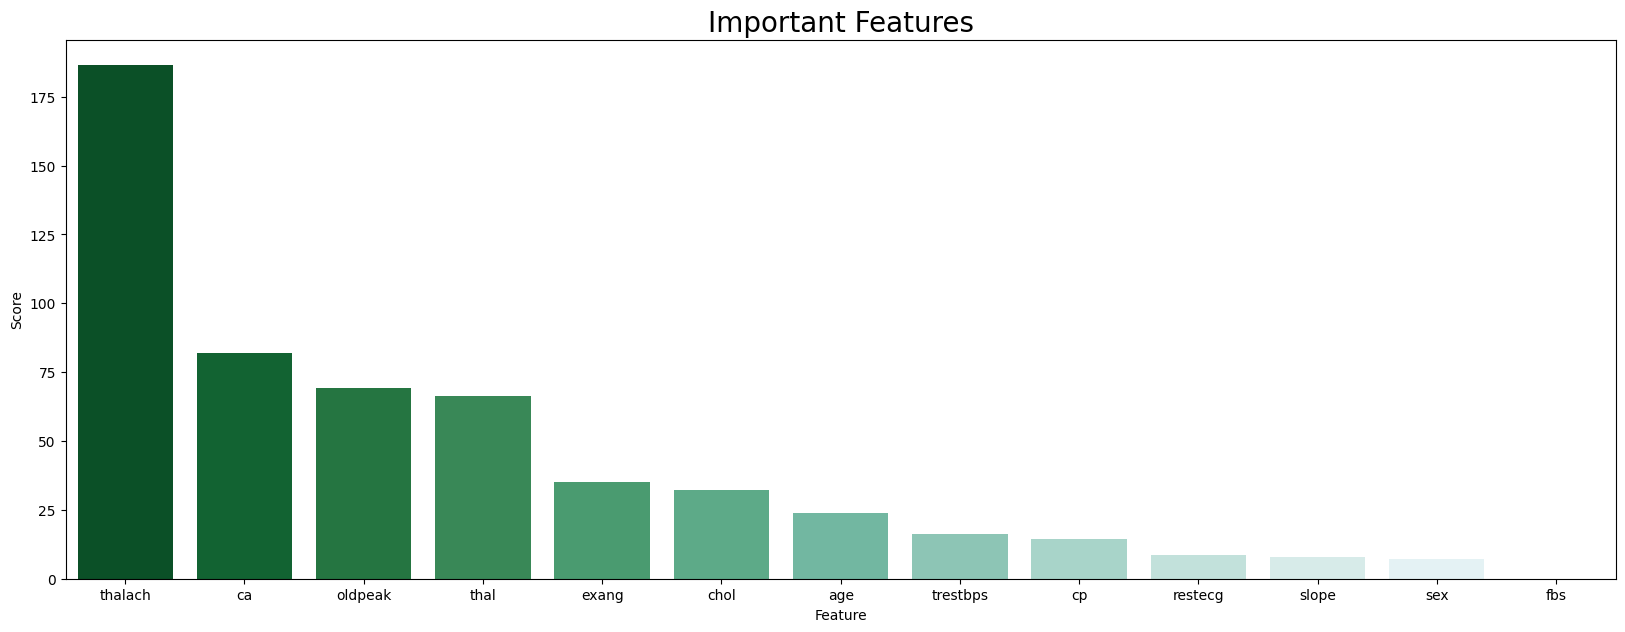

In [40]:
X = cleveland_data.drop(['Target'], axis=1)
y = cleveland_data['Target']

#Apply SelectKBest and extract top 10 features
best = SelectKBest(score_func=chi2, k=10)
fit = best.fit(X,y)

data_scores = pd.DataFrame(fit.scores_)
data_columns = pd.DataFrame(X.columns)

#Join the two dataframes
scores = pd.concat([data_columns,data_scores],axis=1)
scores.columns = ['Feature','Score']
print(scores.nlargest(10,'Score'))

#To visualize feature selection
scores = scores.sort_values(by="Score", ascending=False)
plt.figure(figsize=(20,7), facecolor='w')
sns.barplot(x='Feature',y='Score',data=scores,palette='BuGn_r')
plt.title("Important Features", size=20)
plt.show()

In [41]:
#Select 10 features
features = scores["Feature"].tolist()[:10]
features

['thalach',
 'ca',
 'oldpeak',
 'thal',
 'exang',
 'chol',
 'age',
 'trestbps',
 'cp',
 'restecg']

## Load dataset (Hungary data)

In [301]:
hungarian_data = pd.read_csv("processed.hungarian.data", header=None, names = col_names)

In [302]:
hungarian_data

age  sex  cp trestbps chol fbs restecg thalach exang  oldpeak slope ca  \
0     28    1   2      130  132   0       2     185     0      0.0     ?  ?   
1     29    1   2      120  243   0       0     160     0      0.0     ?  ?   
2     29    1   2      140    ?   0       0     170     0      0.0     ?  ?   
3     30    0   1      170  237   0       1     170     0      0.0     ?  ?   
4     31    0   2      100  219   0       1     150     0      0.0     ?  ?   
..   ...  ...  ..      ...  ...  ..     ...     ...   ...      ...   ... ..   
289   52    1   4      160  331   0       0      94     1      2.5     ?  ?   
290   54    0   3      130  294   0       1     100     1      0.0     2  ?   
291   56    1   4      155  342   1       0     150     1      3.0     2  ?   
292   58    0   2      180  393   0       0     110     1      1.0     2  ?   
293   65    1   4      130  275   0       1     115     1      1.0     2  ?   

    thal  target  
0      ?       0  
1      ?       0  
2      ?       0  
3      6       0  
4      ?       0  
..   ...     ...  
289    ?       1  
290    ?       1  
291    ?       1  
292    7       1  
293    ?       1  

[294 rows x 14 columns]

In [303]:
hungarian_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  294 non-null    object 
 4   chol      294 non-null    object 
 5   fbs       294 non-null    object 
 6   restecg   294 non-null    object 
 7   thalach   294 non-null    object 
 8   exang     294 non-null    object 
 9   oldpeak   294 non-null    float64
 10  slope     294 non-null    object 
 11  ca        294 non-null    object 
 12  thal      294 non-null    object 
 13  target    294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


In [304]:
hungarian_data['target'].value_counts()

0    188
1    106
Name: target, dtype: int64

In [305]:
hungarian_data.nunique()

age          38
sex           2
cp            4
trestbps     32
chol        154
fbs           3
restecg       4
thalach      72
exang         3
oldpeak      10
slope         4
ca            2
thal          4
target        2
dtype: int64

In [306]:
hungarian_data = hungarian_data.drop(columns = ['slope', 'ca', 'thal'], axis = 1)
hungarian_data

age  sex  cp trestbps chol fbs restecg thalach exang  oldpeak  target
0     28    1   2      130  132   0       2     185     0      0.0       0
1     29    1   2      120  243   0       0     160     0      0.0       0
2     29    1   2      140    ?   0       0     170     0      0.0       0
3     30    0   1      170  237   0       1     170     0      0.0       0
4     31    0   2      100  219   0       1     150     0      0.0       0
..   ...  ...  ..      ...  ...  ..     ...     ...   ...      ...     ...
289   52    1   4      160  331   0       0      94     1      2.5       1
290   54    0   3      130  294   0       1     100     1      0.0       1
291   56    1   4      155  342   1       0     150     1      3.0       1
292   58    0   2      180  393   0       0     110     1      1.0       1
293   65    1   4      130  275   0       1     115     1      1.0       1

[294 rows x 11 columns]

In [307]:
## Numeric features
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak']

## Change column format from object to numeric
hungarian_data[features] = hungarian_data[features].apply(pd.to_numeric, errors='coerce')

C:\Users\praga\AppData\Local\Temp\ipykernel_18040\2526235561.py:4: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>],
       [<Axes: title={'center': 'trestbps'}>,
        <Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>],
       [<Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>,
        <Axes: title={'center': 'exang'}>],
       [<Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'target'}>, <Axes: >]], dtype=object)

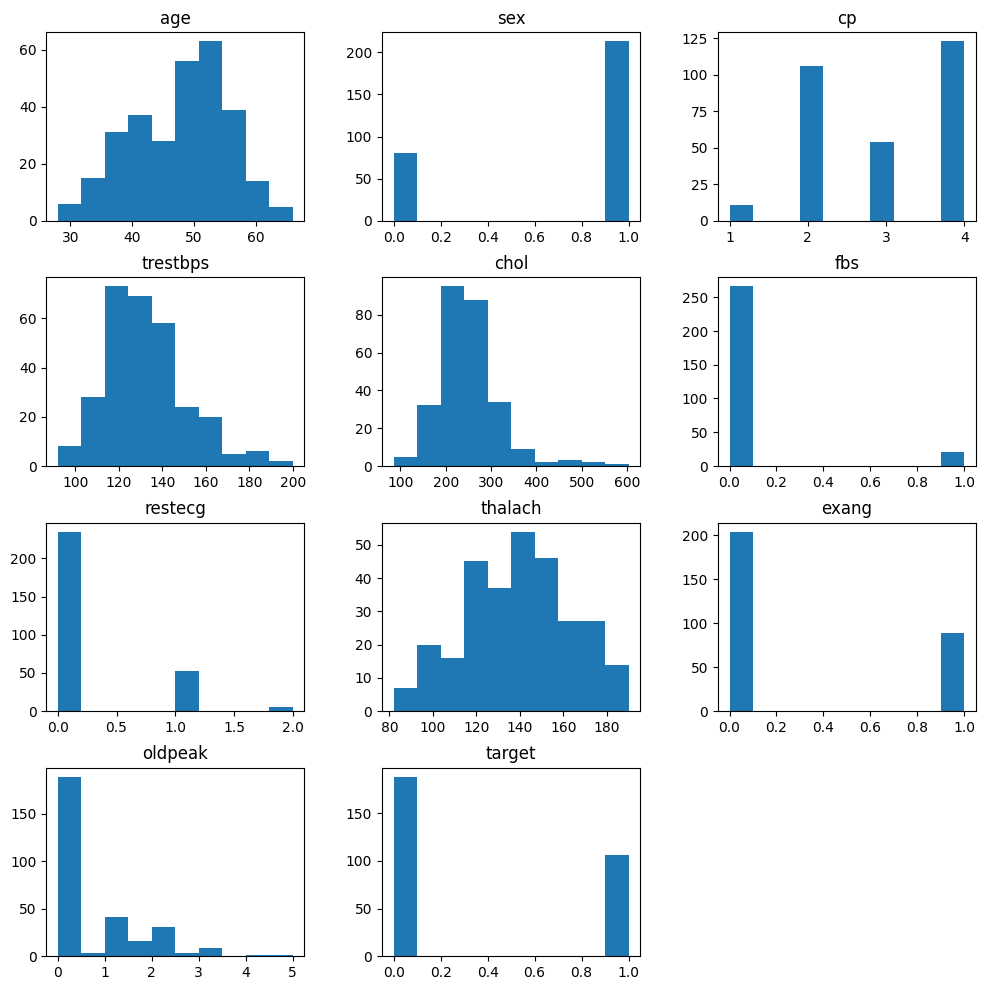

In [308]:
# checking features distributions using histograms
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
hungarian_data.hist(ax = ax, grid = False)

In [309]:
hungarian_data.replace('?', pd.NA, inplace = True)

In [310]:
hungarian_data.isnull().sum()

age          0
sex          0
cp           0
trestbps     1
chol        23
fbs          8
restecg      1
thalach      1
exang        1
oldpeak      0
target       0
dtype: int64

In [311]:
hungarian_data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'target'],
      dtype='object')

In [312]:
hungarian_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  target    294 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 25.4 KB


### Missing value imputation

In [313]:
numerical_features = ['trestbps', 'chol', 'thalach']

for feature in numerical_features:
    hungarian_data[feature] = hungarian_data[feature].fillna(hungarian_data[feature].mean())

In [314]:
categorical_features = ['restecg', 'fbs', 'exang']

for feature in categorical_features:
    hungarian_data[feature] = hungarian_data[feature].fillna(hungarian_data[feature].mode().iloc[0])

In [315]:
hungarian_data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
target      0
dtype: int64

In [316]:
hungarian_data.to_csv('hungarian_preprocessed_data_ps.csv', index = False)

In [317]:
df = hungarian_data

    Feature       Score
4      chol  201.783304
7   thalach  128.014611
9   oldpeak  122.921960
8     exang   70.046164
2        cp   23.412219
3  trestbps   13.331794
0       age    9.488843
5       fbs    7.268175
1       sex    6.027182
6   restecg    0.291753


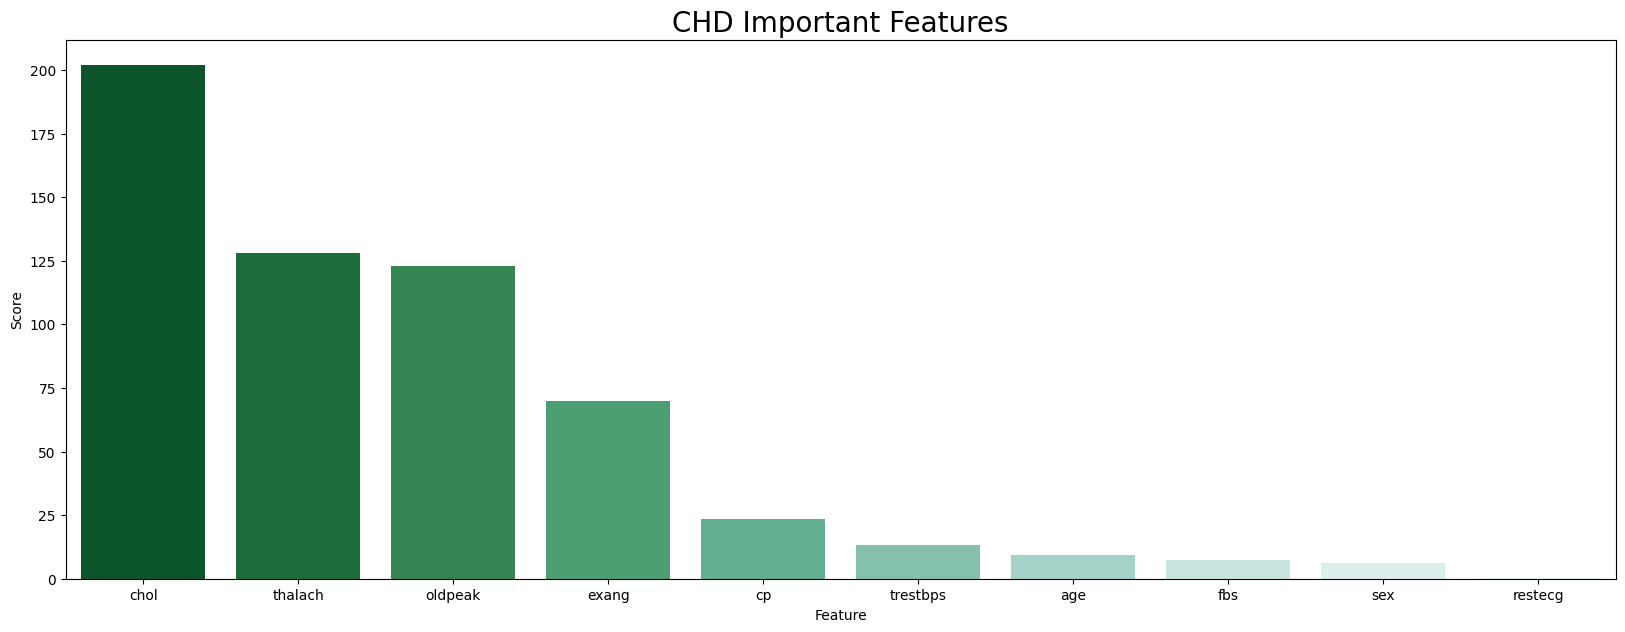

In [318]:
X = df.drop(['target'], axis=1)
y = df['target']

#Apply SelectKBest and extract top 10 features
best = SelectKBest(score_func=chi2, k=10)
fit = best.fit(X,y)

data_scores = pd.DataFrame(fit.scores_)
data_columns = pd.DataFrame(X.columns)

#Join the two dataframes
scores = pd.concat([data_columns,data_scores],axis=1)
scores.columns = ['Feature','Score']
print(scores.nlargest(10,'Score'))

#To visualize feature selection
scores = scores.sort_values(by="Score", ascending=False)
plt.figure(figsize=(20,7), facecolor='w')
sns.barplot(x='Feature',y='Score',data=scores,palette='BuGn_r')
plt.title("CHD Important Features", size=20)
plt.show()

<Axes: >

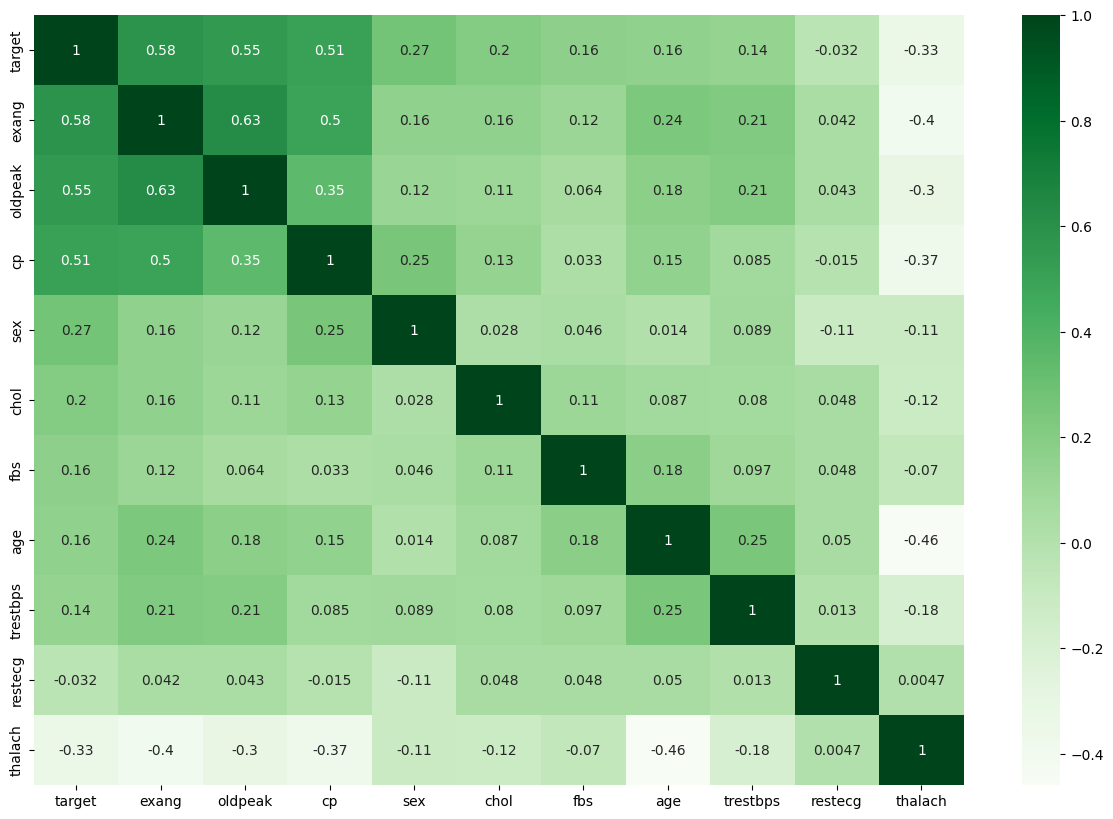

In [322]:
col = hungarian_data.corr().nlargest(31, "target").target.index
plt.figure(figsize=(15, 10))
sns.heatmap(hungarian_data[col].corr(), annot=True, cmap='Greens', annot_kws={"size":10})

### Feature Scaling

In [60]:
## scale numeric features
scaler = StandardScaler()
columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

## Model Prediction on Unseen Hungary data

- We trained our model on 'Cleveland' dataset and doing prediction on 'Hungary' dataset

In [61]:
clev_data

pid       age  sex  cp  trestbps      chol  fbs  restecg   thalach  \
0      P1  0.942285    1   1  0.747060 -0.273149    1        2  0.019003   
1      P2  1.385714    1   4  1.592788  0.816946    0        2 -1.812373   
2      P3  1.385714    1   4 -0.662487 -0.355421    0        2 -0.896685   
3      P4 -1.939999    1   3 -0.098668  0.076504    0        0  1.632359   
4      P5 -1.496571    0   2 -0.098668 -0.869617    0        2  0.978296   
..    ...       ...  ...  ..       ...       ...  ...      ...       ...   
291  P292  0.277143    0   4  0.465150 -0.108607    0        0 -1.158310   
292  P293 -1.053142    1   1 -1.226306  0.364454    0        0 -0.765872   
293  P294  1.496571    1   4  0.690678 -1.095863    1        0 -0.373435   
294  P295  0.277143    1   4 -0.098668 -2.371069    0        0 -1.507144   
295  P296  0.277143    0   2 -0.098668 -0.211446    0        2  1.065504   

     exang   oldpeak  slope  ca  thal  Target  
0        0  1.069137      3   0     6       0  
1        1  0.382849      2   3     3       1  
2        1  1.326494      2   2     7       1  
3        0  2.098568      3   0     3       0  
4        0  0.297063      1   0     3       0  
..     ...       ...    ...  ..   ...     ...  
291      1 -0.732369      2   0     7       1  
292      0  0.125491      2   0     7       1  
293      0  2.012782      2   2     7       1  
294      1  0.125491      2   1     7       1  
295      0 -0.903941      2   1     3       1  

[296 rows x 15 columns]

In [62]:
# Train set as whole dataset (cleveland data)

df_x_train = clev_data.drop(['Target', 'pid', 'slope', 'ca', 'thal'], axis=1)
df_y_train = clev_data['Target']

In [63]:
# Test set (hungarian data)

df_x_test = df.drop(['target'], axis=1)
df_y_test = df['target']

<h3><strong><font color="blue">Logistic Regression</font></strong></h3>

In [64]:
## Model building 

# Fit the model
m1 = LogisticRegression(random_state=42, max_iter = 1000)
m1.fit(df_x_train, df_y_train)

######################################################################################
# Make predictions on the train set
y_pred_train = m1.predict(df_x_train)

# Calculate evaluation metrics
f1 = round(f1_score(df_y_train, y_pred_train), 2)
auc = round(roc_auc_score(df_y_train, y_pred_train), 2)
precision = round(precision_score(df_y_train, y_pred_train), 2)
recall = round(recall_score(df_y_train, y_pred_train), 2)
accuracy = round(accuracy_score(df_y_train, y_pred_train), 2)

# Print Classification report and confusion matrix
print("TRAIN SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(df_y_train, y_pred_train)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(df_y_train, y_pred_train)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn_train, fp_train, fn_train, tp_train = confusion_matrix(df_y_train, y_pred_train).ravel()
print("True Negatives: ",tn_train)
print("False Positives: ",fp_train)
print("False Negatives: ",fn_train)
print("True Positives: ",tp_train)

# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn_train]
]

# Print the evaluation metrics in a table
t1_train = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m1: Logistic Regression', t1_train))
print(t1_train)

##########################################################################################
# Make predictions on the test set
y_pred = m1.predict(df_x_test)


# Calculate evaluation metrics
f1 = round(f1_score(df_y_test, y_pred), 2)
auc = round(roc_auc_score(df_y_test, y_pred), 2)
precision = round(precision_score(df_y_test, y_pred), 2)
recall = round(recall_score(df_y_test, y_pred), 2)
accuracy = round(accuracy_score(df_y_test, y_pred), 2)

# Print Classification report and confusion matrix
print("\nTEST SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(df_y_test,y_pred)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(df_y_test, y_pred)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(df_y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)


# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn]
]

# Print the evaluation metrics in a table
t1_test = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m1: Logistic Regression', t1_test))
print(t1_test)

TRAIN SET RESULTS: 
CONFUSION MATRIX:
[[135  24]
 [ 34 103]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       159
           1       0.81      0.75      0.78       137

    accuracy                           0.80       296
   macro avg       0.80      0.80      0.80       296
weighted avg       0.80      0.80      0.80       296

True Negatives:  135
False Positives:  24
False Negatives:  34
True Positives:  103
╒═════════════════╤═════════╕
│ Metric          │   Value │
╞═════════════════╪═════════╡
│ F1 Score        │    0.78 │
├─────────────────┼─────────┤
│ AUC Score       │    0.8  │
├─────────────────┼─────────┤
│ Precision       │    0.81 │
├─────────────────┼─────────┤
│ Recall          │    0.75 │
├─────────────────┼─────────┤
│ Accuracy        │    0.8  │
├─────────────────┼─────────┤
│ False Negatives │   34    │
╘═════════════════╧═════════╛

TEST SET RESULTS: 
CONFUSION MATRIX:
[[158  30]
 [ 21

<h3><strong><font color="blue">Random Forest Classfier</font></strong></h3>

In [65]:
# Fit the model
m2 = RandomForestClassifier()
m2.fit(df_x_train, df_y_train)

######################################################################################
# Make predictions on the train set
y_pred_train = m2.predict(df_x_train)

# Calculate evaluation metrics
f1 = round(f1_score(df_y_train, y_pred_train), 2)
auc = round(roc_auc_score(df_y_train, y_pred_train), 2)
precision = round(precision_score(df_y_train, y_pred_train), 2)
recall = round(recall_score(df_y_train, y_pred_train), 2)
accuracy = round(accuracy_score(df_y_train, y_pred_train), 2)

# Print Classification report and confusion matrix
print("TRAIN SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(df_y_train, y_pred_train)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(df_y_train, y_pred_train)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn_train, fp_train, fn_train, tp_train = confusion_matrix(df_y_train, y_pred_train).ravel()
print("True Negatives: ",tn_train)
print("False Positives: ",fp_train)
print("False Negatives: ",fn_train)
print("True Positives: ",tp_train)

# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn_train]
]

# Print the evaluation metrics in a table
t2_train = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m2: Random Forest Classifier', t2_train))
print(t2_train)

##########################################################################################
# Make predictions on the test set
y_pred = m2.predict(df_x_test)


# Calculate evaluation metrics
f1 = round(f1_score(df_y_test, y_pred), 2)
auc = round(roc_auc_score(df_y_test, y_pred), 2)
precision = round(precision_score(df_y_test, y_pred), 2)
recall = round(recall_score(df_y_test, y_pred), 2)
accuracy = round(accuracy_score(df_y_test, y_pred), 2)

# Print Classification report and confusion matrix
print("\TEST SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(df_y_test,y_pred)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(df_y_test, y_pred)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(df_y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)


# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn]
]

# Print the evaluation metrics in a table
t2_test = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m2: Random Forest Classifier', t2_test))
print(t2_test)

TRAIN SET RESULTS: 
CONFUSION MATRIX:
[[159   0]
 [  0 137]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       1.00      1.00      1.00       137

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296

True Negatives:  159
False Positives:  0
False Negatives:  0
True Positives:  137
╒═════════════════╤═════════╕
│ Metric          │   Value │
╞═════════════════╪═════════╡
│ F1 Score        │       1 │
├─────────────────┼─────────┤
│ AUC Score       │       1 │
├─────────────────┼─────────┤
│ Precision       │       1 │
├─────────────────┼─────────┤
│ Recall          │       1 │
├─────────────────┼─────────┤
│ Accuracy        │       1 │
├─────────────────┼─────────┤
│ False Negatives │       0 │
╘═════════════════╧═════════╛
\TEST SET RESULTS: 
CONFUSION MATRIX:
[[167  21]
 [ 31  

<h3><strong><font color="blue">Gradient Boosting Classfier</font></strong></h3>

In [66]:
# Fit the model
m3 = GradientBoostingClassifier()
m3.fit(df_x_train, df_y_train)

######################################################################################
# Make predictions on the train set
y_pred_train = m3.predict(df_x_train)

# Calculate evaluation metrics
f1 = round(f1_score(df_y_train, y_pred_train), 2)
auc = round(roc_auc_score(df_y_train, y_pred_train), 2)
precision = round(precision_score(df_y_train, y_pred_train), 2)
recall = round(recall_score(df_y_train, y_pred_train), 2)
accuracy = round(accuracy_score(df_y_train, y_pred_train), 2)

# Print Classification report and confusion matrix
print("TRAIN SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(df_y_train, y_pred_train)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(df_y_train, y_pred_train)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn_train, fp_train, fn_train, tp_train = confusion_matrix(df_y_train, y_pred_train).ravel()
print("True Negatives: ",tn_train)
print("False Positives: ",fp_train)
print("False Negatives: ",fn_train)
print("True Positives: ",tp_train)

# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn_train]
]

# Print the evaluation metrics in a table
t3_train = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m3: Random Forest Classifier', t3_train))
print(t3_train)

##########################################################################################
# Make predictions on the test set
y_pred = m3.predict(df_x_test)


# Calculate evaluation metrics
f1 = round(f1_score(df_y_test, y_pred), 2)
auc = round(roc_auc_score(df_y_test, y_pred), 2)
precision = round(precision_score(df_y_test, y_pred), 2)
recall = round(recall_score(df_y_test, y_pred), 2)
accuracy = round(accuracy_score(df_y_test, y_pred), 2)

# Print Classification report and confusion matrix
print("\TEST SET RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(df_y_test,y_pred)}\n")
print(f"CLASSIFICATION REPORT:\n{classification_report(df_y_test, y_pred)}")

# Extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(df_y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)


# Create a list of metric names and corresponding values
metrics = [
    ["F1 Score", f1],
    ["AUC Score", auc],
    ["Precision", precision],
    ["Recall", recall],
    ["Accuracy", accuracy],
    ["False Negatives", fn]
]

# Print the evaluation metrics in a table
t3_test = tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid")

# Add the table and description to the list
tables.append(('m2: Random Forest Classifier', t3_test))
print(t3_test)

TRAIN SET RESULTS: 
CONFUSION MATRIX:
[[157   2]
 [  5 132]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       159
           1       0.99      0.96      0.97       137

    accuracy                           0.98       296
   macro avg       0.98      0.98      0.98       296
weighted avg       0.98      0.98      0.98       296

True Negatives:  157
False Positives:  2
False Negatives:  5
True Positives:  132
╒═════════════════╤═════════╕
│ Metric          │   Value │
╞═════════════════╪═════════╡
│ F1 Score        │    0.97 │
├─────────────────┼─────────┤
│ AUC Score       │    0.98 │
├─────────────────┼─────────┤
│ Precision       │    0.99 │
├─────────────────┼─────────┤
│ Recall          │    0.96 │
├─────────────────┼─────────┤
│ Accuracy        │    0.98 │
├─────────────────┼─────────┤
│ False Negatives │    5    │
╘═════════════════╧═════════╛
\TEST SET RESULTS: 
CONFUSION MATRIX:
[[153  35]
 [ 27  

<h3><strong><font color="blue">Neural Network [DGL]</font></strong></h3>

In [67]:
test = df.copy()

In [68]:
test

age  sex  cp  trestbps      chol  fbs  restecg   thalach  exang  \
0   -2.542347    1   2 -0.147076 -1.833027  0.0      2.0  1.951150    0.0   
1   -2.414117    1   2 -0.716341 -0.121052  0.0      0.0  0.887744    0.0   
2   -2.414117    1   2  0.422189  0.000000  0.0      0.0  1.313106    0.0   
3   -2.285888    0   1  2.129984 -0.213591  0.0      1.0  1.313106    0.0   
4   -2.157658    0   2 -1.854871 -0.491209  0.0      1.0  0.462382    0.0   
..        ...  ...  ..       ...       ...  ...      ...       ...    ...   
289  0.535162    1   4  1.560719  1.236189  0.0      0.0 -1.919647    1.0   
290  0.791621    0   3 -0.147076  0.665531  0.0      1.0 -1.664429    1.0   
291  1.048080    1   4  1.276086  1.405845  1.0      0.0  0.462382    1.0   
292  1.304539    0   2  2.699249  2.192428  0.0      0.0 -1.239067    1.0   
293  2.202146    1   4 -0.147076  0.372490  0.0      1.0 -1.026386    1.0   

      oldpeak  target  
0   -0.646074       0  
1   -0.646074       0  
2   -0.646074       0  
3   -0.646074       0  
4   -0.646074       0  
..        ...     ...  
289  2.109958       1  
290 -0.646074       1  
291  2.661164       1  
292  0.456339       1  
293  0.456339       1  

[294 rows x 11 columns]

In [69]:
df_train = clev_data.copy()

df_train = df_train.drop(columns = ['slope', 'ca', 'thal', 'pid'], axis = 1)
df_train = df_train.rename(columns = {'Target':'target'})
df_train                  

age  sex  cp  trestbps      chol  fbs  restecg   thalach  exang  \
0    0.942285    1   1  0.747060 -0.273149    1        2  0.019003      0   
1    1.385714    1   4  1.592788  0.816946    0        2 -1.812373      1   
2    1.385714    1   4 -0.662487 -0.355421    0        2 -0.896685      1   
3   -1.939999    1   3 -0.098668  0.076504    0        0  1.632359      0   
4   -1.496571    0   2 -0.098668 -0.869617    0        2  0.978296      0   
..        ...  ...  ..       ...       ...  ...      ...       ...    ...   
291  0.277143    0   4  0.465150 -0.108607    0        0 -1.158310      1   
292 -1.053142    1   1 -1.226306  0.364454    0        0 -0.765872      0   
293  1.496571    1   4  0.690678 -1.095863    1        0 -0.373435      0   
294  0.277143    1   4 -0.098668 -2.371069    0        0 -1.507144      1   
295  0.277143    0   2 -0.098668 -0.211446    0        2  1.065504      0   

      oldpeak  target  
0    1.069137       0  
1    0.382849       1  
2    1.326494       1  
3    2.098568       0  
4    0.297063       0  
..        ...     ...  
291 -0.732369       1  
292  0.125491       1  
293  2.012782       1  
294  0.125491       1  
295 -0.903941       1  

[296 rows x 11 columns]

In [70]:
train = df_train[:200]
val = df_train[200:]

In [71]:
print(train.shape)
print(val.shape)
print(test.shape)

(200, 11)
(96, 11)
(294, 11)


In [72]:
train['train'] = True
train['test'] = False
train['validate'] = False

test['train'] = False
test['test'] = True
test['validate'] = False

val['train'] = False
val['test'] = False
val['validate'] = True

results_df = pd.concat([train, test, val]).sort_index(ascending=True)

In [73]:
results_df = results_df.sort_values(by = ['train', 'test', 'validate'], ascending = [False, False, False])

In [74]:
results_df

age  sex  cp  trestbps      chol  fbs  restecg   thalach  exang  \
0    0.942285    1   1  0.747060 -0.273149  1.0      2.0  0.019003    0.0   
1    1.385714    1   4  1.592788  0.816946  0.0      2.0 -1.812373    1.0   
2    1.385714    1   4 -0.662487 -0.355421  0.0      2.0 -0.896685    1.0   
3   -1.939999    1   3 -0.098668  0.076504  0.0      0.0  1.632359    0.0   
4   -1.496571    0   2 -0.098668 -0.869617  0.0      2.0  0.978296    0.0   
..        ...  ...  ..       ...       ...  ...      ...       ...    ...   
291  0.277143    0   4  0.465150 -0.108607  0.0      0.0 -1.158310    1.0   
292 -1.053142    1   1 -1.226306  0.364454  0.0      0.0 -0.765872    0.0   
293  1.496571    1   4  0.690678 -1.095863  1.0      0.0 -0.373435    0.0   
294  0.277143    1   4 -0.098668 -2.371069  0.0      0.0 -1.507144    1.0   
295  0.277143    0   2 -0.098668 -0.211446  0.0      2.0  1.065504    0.0   

      oldpeak  target  train   test  validate  
0    1.069137       0   True  False     False  
1    0.382849       1   True  False     False  
2    1.326494       1   True  False     False  
3    2.098568       0   True  False     False  
4    0.297063       0   True  False     False  
..        ...     ...    ...    ...       ...  
291 -0.732369       1  False  False      True  
292  0.125491       1  False  False      True  
293  2.012782       1  False  False      True  
294  0.125491       1  False  False      True  
295 -0.903941       1  False  False      True  

[590 rows x 14 columns]

In [75]:
print(results_df['train'].value_counts())
print(results_df['validate'].value_counts())
print(results_df['test'].value_counts())

False    390
True     200
Name: train, dtype: int64
False    494
True      96
Name: validate, dtype: int64
False    296
True     294
Name: test, dtype: int64


In [76]:
results_df.to_csv('clev_hungry_combined_preprocessed_data.csv', index = False)

In [77]:
X = dgl.DGLGraph()

X.add_nodes(len(results_df))

X = dgl.add_self_loop(X)

C:\Users\praga\.conda\envs\prag39\lib\site-packages\dgl\heterograph.py:92: DGLWarning:

Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.



In [78]:
np_val = np.array(results_df['validate'])
t_val = torch.from_numpy(np_val)

np_train = np.array(results_df['train'])
t_train = torch.from_numpy(np_train)

np_test = np.array(results_df['test'])
t_test = torch.from_numpy(np_test)

np_label = np.array(results_df['target'])
t_label = torch.from_numpy(np_label)

In [79]:
results_df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'target', 'train', 'test', 'validate'],
      dtype='object')

In [80]:
np_f1 = np.array(results_df['age']).astype(np.float32)
t_f1 = torch.from_numpy(np_f1)

np_f2 = np.array(results_df['sex']).astype(np.float32)
t_f2 = torch.from_numpy(np_f2)

np_f3 = np.array(results_df['cp']).astype(np.float32)
t_f3 = torch.from_numpy(np_f3)

np_f4 = np.array(results_df['trestbps']).astype(np.float32)
t_f4 = torch.from_numpy(np_f4)

np_f5 = np.array(results_df['chol']).astype(np.float32)
t_f5 = torch.from_numpy(np_f5)

np_f6 = np.array(results_df['fbs']).astype(np.float32)
t_f6 = torch.from_numpy(np_f6)

np_f7 = np.array(results_df['restecg']).astype(np.float32)
t_f7 = torch.from_numpy(np_f7)

np_f8 = np.array(results_df['thalach']).astype(np.float32)
t_f8 = torch.from_numpy(np_f8)

np_f9 = np.array(results_df['exang']).astype(np.float32)
t_f9 = torch.from_numpy(np_f9)

np_f10 = np.array(results_df['oldpeak']).astype(np.float32)
t_f10 = torch.from_numpy(np_f10)

In [81]:
X.ndata['label'] = t_label
X.ndata['val_mask'] = t_val
X.ndata['train_mask'] = t_train
X.ndata['test_mask'] = t_test

X.ndata['feat'] = torch.cat([t_f1.unsqueeze(1), t_f2.unsqueeze(1), t_f3.unsqueeze(1), t_f4.unsqueeze(1), t_f5.unsqueeze(1), t_f6.unsqueeze(1), t_f7.unsqueeze(1), t_f8.unsqueeze(1), t_f9.unsqueeze(1), t_f10.unsqueeze(1)], dim=1)


In [83]:
# Set the random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

<h4><strong><font color="green">GCN (Graph Convolutional Network)</font></strong></h4>

In [147]:
class Net(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, dropout_prob=0.5):
        super().__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        self.dense_layer1 = nn.Linear(num_classes, num_classes)
        self.dense_layer2 = nn.Linear(num_classes, num_classes)
        self.dense_layer3 = nn.Linear(num_classes, num_classes)
        self.dropout = nn.Dropout(p=dropout_prob)
        # self.pooling = nn.MaxPool1d(1)

    def forward(self, g, in_feat):
        with g.local_scope():
            h = self.conv1(g, in_feat)
            h = F.relu(h)
            h = self.conv2(g, h)
            h = self.dense_layer1(h)
            h = F.relu(h)
            h = self.dense_layer2(h)
            h = self.dense_layer3(h)
            h = self.dropout(h)
            # h = h.unsqueeze(0)
            # h = self.pooling(h)
            #h = h.squeeze(0)

            return h

def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        pred = logits.argmax(1)
        logp = F.log_softmax(logits, 1)
        loss = F.cross_entropy(logits[mask], labels[mask])

        acc = (pred[mask] == labels[mask]).float().mean()
        auc = roc_auc_score(labels[mask].detach().numpy(), logp[mask].detach().numpy()[:, 1])
        f1 = f1_score(labels[mask].detach().numpy(), pred[mask].detach().numpy())
        precision = precision_score(labels[mask].detach().numpy(), pred[mask].detach().numpy(), zero_division=1)
        recall = recall_score(labels[mask].detach().numpy(), pred[mask].detach().numpy())
        
    return loss, acc, auc, f1, precision, recall

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def train(g, model, min_delta=0.01, patience=100):
    set_seed(42)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0
    best_val_auc = 0
    best_test_auc = 0   
    best_val_f1 = 0
    best_test_f1 = 0
    best_val_precision = 0
    best_test_precision = 0 
    best_val_recall = 0
    best_test_recall = 0
    best_epoch = 0
    
    logits = model(g, g.ndata['feat'])
    
    features = g.ndata['feat']
    labels = g.ndata['label']
    
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    
    counter = 0
    
    for epoch in range(1000):
        model.train()
        optimizer.zero_grad()
        logits = model(g, features)
        
        train_loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        
        val_loss, val_acc, val_auc, val_f1, val_precision, val_recall = evaluate(model, g, features, labels, val_mask)
        test_loss, test_acc, test_auc, test_f1, test_precision, test_recall = evaluate(model, g, features, labels, test_mask)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            best_val_auc = val_auc
            best_test_auc = test_auc
            best_val_f1 = val_f1
            best_test_f1 = test_f1
            best_val_precision = val_precision
            best_test_precision = test_precision
            best_val_recall = val_recall
            best_test_recall = test_recall
            best_epoch = epoch
            counter = 0
        else:
            counter += 1
        
        if counter >= patience:
            print("Early stopping at epoch:", epoch)
            break
        
        train_loss.backward()
        optimizer.step()
    
    print("Best Validation Accuracy:", round(best_val_acc.item(), 2))
    print("Best Test Accuracy:", round(best_test_acc.item(), 2))
    print("Best Validation AUC:", round(best_val_auc.item(), 2))
    print("Best Test AUC:", round(best_test_auc.item(), 2))
    print("Best Validation F1 Score:", round(best_val_f1.item(), 2))
    print("Best Test F1 Score:", round(best_test_f1.item(), 2))
    print("Best Validation Precision Score:", round(best_val_precision.item(), 2))
    print("Best Test Precision Score:", round(best_test_precision.item(), 2))
    print("Best Validation Recall Score:", round(best_val_recall.item(), 2))
    print("Best Test Recall Score:", round(best_test_recall.item(), 2))    
    
    return model, best_epoch

In [161]:
model = Net(X.ndata['feat'].shape[1], 32, 2)
best_model, best_epoch = train(X, model)
print("\nBest model at epoch:", best_epoch)

best_model

## as you increase the dimension, model performance gets reduced

Early stopping at epoch: 149
Best Validation Accuracy: 0.78
Best Test Accuracy: 0.81
Best Validation AUC: 0.84
Best Test AUC: 0.85
Best Validation F1 Score: 0.75
Best Test F1 Score: 0.73
Best Validation Precision Score: 0.86
Best Test Precision Score: 0.73
Best Validation Recall Score: 0.66
Best Test Recall Score: 0.74

Best model at epoch: 49


Net(
  (conv1): GraphConv(in=10, out=32, normalization=both, activation=None)
  (conv2): GraphConv(in=32, out=2, normalization=both, activation=None)
  (dense_layer1): Linear(in_features=2, out_features=2, bias=True)
  (dense_layer2): Linear(in_features=2, out_features=2, bias=True)
  (dense_layer3): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

<h4><strong><font color="green">GAT (Graph Attention Network)</font></strong></h4>

In [276]:
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        # reinitialize learnable parameters
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')
    
def edge_attention(self, edges):
    # edge UDF for equation (2)
    z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
    a = self.attn_fc(z2)
    return {'e' : F.leaky_relu(a)}

def reduce_func(self, nodes):
    # reduce UDF for equation (3) & (4)
    # equation (3)
    alpha = F.softmax(nodes.mailbox['e'], dim=1)
    # equation (4)
    h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
    return {'h' : h}

In [286]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for _ in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            out = torch.cat(head_outs, dim=1)
        else:
            # merge using average
            out = torch.mean(torch.stack(head_outs), dim=0)
        out = self.dropout(out)
        return out
        
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)
        self.pooling = nn.MaxPool1d(1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        h = h.unsqueeze(0)  
        h = self.pooling(h)
        h = h.squeeze(0)
        return h

def evaluate(model, g, h, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, h)
        pred = logits.argmax(1)
        logp = F.log_softmax(logits, 1)

        acc = (pred[mask] == labels[mask]).float().mean()
        auc = roc_auc_score(labels[mask].detach().numpy(), logp[mask].detach().numpy()[:, 1])
        f1 = f1_score(labels[mask].detach().numpy(), pred[mask].detach().numpy())
        precision = precision_score(labels[mask].detach().numpy(), pred[mask].detach().numpy(), zero_division=1)
        recall = recall_score(labels[mask].detach().numpy(), pred[mask].detach().numpy())

    return acc, auc, f1, precision, recall

In [287]:
def train(X, model, min_delta=0.01, patience=100, weight_decay=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
    
    best_val_acc = 0
    best_test_acc = 0
    best_val_auc = 0
    best_test_auc = 0   
    best_val_f1 = 0
    best_test_f1 = 0
    best_val_precision = 0
    best_test_precision = 0 
    best_val_recall = 0
    best_test_recall = 0
    best_epoch = 0
    
    features = X.ndata['feat']
    labels = X.ndata['label']
    train_mask = X.ndata['train_mask']
    val_mask = X.ndata['val_mask']
    test_mask = X.ndata['test_mask']
    
    counter = 0
    
    for e in range(1000):
        # Forward
        logits = model(features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        logp = F.log_softmax(logits, 1)
        
        train_loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        val_loss = F.cross_entropy(logits[val_mask], labels[val_mask])
        test_loss = F.cross_entropy(logits[test_mask], labels[test_mask])
        
        l2_loss = sum(p.pow(2).sum() for p in model.parameters()) * weight_decay
        loss = train_loss + l2_loss

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        
        # Calculate AUC score on validation/test
        val_auc = roc_auc_score(labels[val_mask].detach().numpy(), logp[val_mask].detach().numpy()[:, 1])
        test_auc = roc_auc_score(labels[test_mask].detach().numpy(), logp[test_mask].detach().numpy()[:, 1])
        
        # Calculate F1 score on validation/test
        val_f1 = f1_score(labels[val_mask].detach().numpy(), pred[val_mask].detach().numpy())
        test_f1 = f1_score(labels[test_mask].detach().numpy(), pred[test_mask].detach().numpy())

        # Calculate Precision on validation/test
        val_precision = precision_score(labels[val_mask].detach().numpy(), pred[val_mask].detach().numpy(), zero_division=1)
        test_precision = precision_score(labels[test_mask].detach().numpy(), pred[test_mask].detach().numpy(), zero_division=1)

        # Calculate Recall on validation/test
        val_recall = recall_score(labels[val_mask].detach().numpy(), pred[val_mask].detach().numpy())
        test_recall = recall_score(labels[test_mask].detach().numpy(), pred[test_mask].detach().numpy())
        
    
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            best_val_auc = val_auc
            best_test_auc = test_auc
            best_val_f1 = val_f1
            best_test_f1 = test_f1
            best_val_precision = val_precision
            best_test_precision = test_precision
            best_val_recall = val_recall
            best_test_recall = test_recall
            best_epoch = e
            counter = 0
        else:
            counter += 1
        
        if counter >= patience:
            print("Early stopping at epoch:", e)
            break
            
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Best Validation Accuracy:", round(best_val_acc.item(), 2))
    print("Best Test Accuracy:", round(best_test_acc.item(), 2))
    print("Best Validation AUC:", round(best_val_auc.item(), 2))
    print("Best Test AUC:", round(best_test_auc.item(), 2))
    print("Best Validation F1 Score:", round(best_val_f1.item(), 2))
    print("Best Test F1 Score:", round(best_test_f1.item(), 2))
    print("Best Validation Precision Score:", round(best_val_precision.item(), 2))
    print("Best Test Precision Score:", round(best_test_precision.item(), 2))
    print("Best Validation Recall Score:", round(best_val_recall.item(), 2))
    print("Best Test Recall Score:", round(best_test_recall.item(), 2))    
    
    return model, best_epoch

In [290]:
# create the model with multiple n heads, each head has hidden size 64
net = GAT(X, in_dim=X.ndata['feat'].shape[1], hidden_dim=64, out_dim=2, num_heads=10)
best_model, best_epoch = train(X, net)
print("\nBest model at epoch:", best_epoch)

best_model

## GAT takes more time to run as compared to GCN (as you increase num_heads)

Early stopping at epoch: 147
Best Validation Accuracy: 0.78
Best Test Accuracy: 0.72
Best Validation AUC: 0.84
Best Test AUC: 0.8
Best Validation F1 Score: 0.74
Best Test F1 Score: 0.61
Best Validation Precision Score: 0.88
Best Test Precision Score: 0.62
Best Validation Recall Score: 0.64
Best Test Recall Score: 0.59

Best model at epoch: 47


GAT(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0-9): 10 x GATLayer(
        (fc): Linear(in_features=10, out_features=64, bias=False)
        (attn_fc): Linear(in_features=128, out_features=1, bias=False)
      )
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=640, out_features=2, bias=False)
        (attn_fc): Linear(in_features=4, out_features=1, bias=False)
      )
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (pooling): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
)